# Capstone Project 1: Instacart Market Basket Analysis
Predicting Customer's Diet Classification

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
import seaborn as sns
from matplotlib import rcParams
from scipy import stats
sns.set(style="whitegrid", color_codes=True)
sns.set_context("poster")

In [2]:
## Read and Save all Tables in a DF
prod=pd.read_csv('products.csv')
aisles=pd.read_csv('aisles.csv')
dep=pd.read_csv('departments.csv')
orders=pd.read_csv('orders.csv')
train=pd.read_csv('order_products__train.csv')
prior=pd.read_csv('order_products__prior.csv')
samp=pd.read_csv('sample_submission.csv')

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
## Orders Table Separated to three
oprior=orders[orders.eval_set=='prior']
otrain=orders[orders.eval_set=='train']
otest=orders[orders.eval_set=='test']

In [5]:
oprior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
## Total number of Customers that are in oprior dataframe
oprior.user_id.unique().size

206209

In [7]:
##Merging Oprior DataFrame with prod and aisle dataframes
Allprior=oprior.merge(prior)
Allprior=Allprior.merge(prod)
Allprior=Allprior.merge(aisles)

In [8]:
Allprior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks


In [9]:
##Percentage of orders coming from each aisle in the entire Allprior dataframe
aisle_percent=Allprior.aisle_id.value_counts()/Allprior.aisle_id.size
aisle_percent=pd.DataFrame(aisle_percent).sort_index().reset_index()
aisle_percent.columns=['aisle_id', 'aisle_percent']
aisle_percent.head()


,aisle_id,aisle_percent
0,1,0.002218
1,2,0.002543
2,3,0.014071
3,4,0.006187
4,5,0.001927


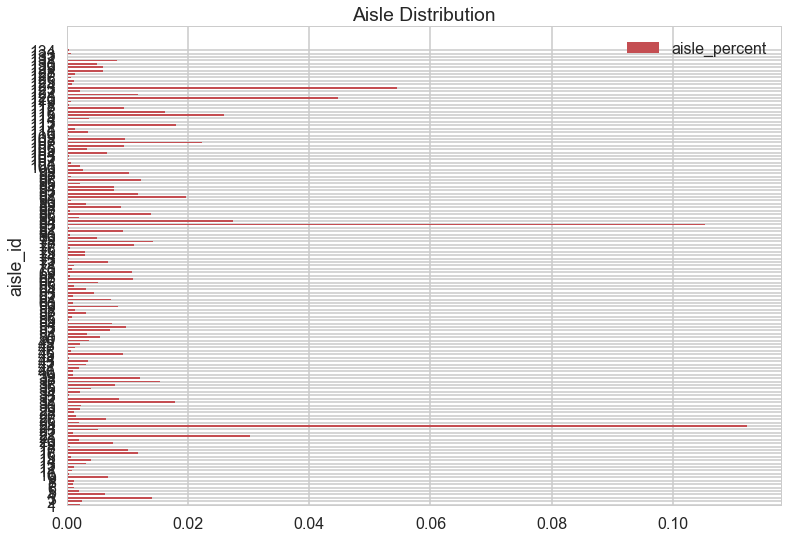

In [77]:
aisle_percent.plot("aisle_id", "aisle_percent", kind="barh", color='r')
plt.title('Aisle Distribution')
plt.ylim(0,140)
plt.show()

In [11]:
## U is the dataframe of users with their number of orders
U=oprior.groupby('user_id')['order_number'].agg(['max'])
U['user_id']=U.index.get_level_values('user_id').values
U.columns=['max_order', 'user_id']

In [12]:
## P_num is the dataframe of users with order_id and the number of products per order
P_num=Allprior.groupby('user_id')['order_id'].value_counts()
P_num=pd.DataFrame(P_num)
P_num.columns=['prod_per_order']
P_num['user_id']=P_num.index.get_level_values('user_id').values
P_num['order_id']=P_num.index.get_level_values('order_id').values

In [13]:
### Tot_p is the dataframe of users with total number of products they ordered
Tot_p=Allprior.user_id.value_counts()
Tot_p=pd.DataFrame(Tot_p).reset_index()
Tot_p.columns=['user_id', 'total_products']

##  F1. This function provides a sample of 10,000 random users from the oprior dataframe for training dataset

In [14]:
def Sample_maker(Q):
    PO=Q.merge(P_num).merge(Tot_p)
    sample1=Q.sample(n=10000, replace=False, random_state=0, axis=0)
    
    ## sample1 is the DataFrame of the first dataset
    sample1=sample1.merge(PO, how='inner')
    sample1=sample1.loc[:,['user_id', 'order_id', 'max_order', 'prod_per_order', 'total_products']]


    #Emp is the Empirical dataframe
    Emp=sample1.merge(Allprior, how='inner')
    
    return Emp

## F2. This Function classifies Users as Meat_Lovers, Pescatarian, Vegan, NonVegan according to users overall order history

In [15]:
def Diet_Class_user(A):
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.user_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['user_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.user_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['user_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.user_id.isin(MS.user_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.user_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['user_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.user_id.isin(F1)]
    Vega=Vegans.user_id.unique()
    Vega=pd.DataFrame(Vega, columns=['user_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    return Sample_class

## F3. This Function classifies Meat_Lovers, Pescatarian, Vegan, NonVegan according to orders and disregarding who ordered it (the user)

In [16]:
def Diet_Class_orders(A):
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.order_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['order_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.order_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['order_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.order_id.isin(MS.order_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.order_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['order_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.order_id.isin(F1)]
    Vega=Vegans.order_id.unique()
    Vega=pd.DataFrame(Vega, columns=['order_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    return Sample_class

## F4. This function returns a horizontal bar graph of distrubution of the four Diet Categories of Customers 

In [17]:
def Diet_Percentage(B):
    Per=B.Diet.value_counts()
    Per=pd.DataFrame(Per).reset_index()
    Per.columns=['Diet','Size']
    Per['Percent']=Per.Size/Per.Size.sum()
    
    #Bar=Per.sort_index().plot(kind='barh', color='r')
    #plt.xlabel('Percentage')
    #plt.title('Customer Diet Distribution')
    return Per

## F5. This function excludes the 10,000 users previously used in a training dataset 

In [18]:
def Remaining_users(S): ## S is an Empirical Sample Generated DataFrame (E1, E2, E3)
    Rem=U.loc[~U.user_id.isin(S.user_id)]
    return Rem
    

## Three Empirical Samples are Generated and Customer's Diet Classified

In [19]:
## First Empirical Sample with 10,000 users from oprior DataFrame

E1=Sample_maker(U)           # Empirical Sample Generated
C1=Diet_Class_user(E1)       # Diets are of 10,000 in the Empirical Sample Classified
P1=Diet_Percentage(C1)       # This returns the percentage of the different Diet Classification
P1

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,6426,0.6426
1,NonVegan,2336,0.2336
2,Vegan,774,0.0774
3,Pescatarian,464,0.0464


In [20]:
## Second Empirical Sample with 10,000 users from oprior DataFrame
U1=Remaining_users(E1)      # The 10,000 users in the first Emprical Sample (E1) is excluded from the oprior DataFrame

E2=Sample_maker(U1)         # Empirical Sample Generated
C2=Diet_Class_user(E2)      # Diets are of 10,000 in the Empirical Sample Classified
P2=Diet_Percentage(C2)      # This returns the percentage of the different Diet Classification
P2

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,6517,0.6517
1,NonVegan,2294,0.2294
2,Vegan,691,0.0691
3,Pescatarian,498,0.0498


In [21]:
## Third Empirical Sample with 10,000 users from oprior DataFrame

ET=pd.concat([E1,E2])           # The first two Empirical Sample were merged a
U2=Remaining_users(ET)      # The 10,000 users in the first and second Emprical Sample (E1+E2) is excluded from the oprior DataFrame
E3=Sample_maker(U2)         # Empirical Sample Generated
C3=Diet_Class_user(E3)      # Diets are of 10,000 in the Empirical Sample Classified
P3=Diet_Percentage(C3)      # This returns the percentage of the different Diet Classification
P3

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,6511,0.6511
1,NonVegan,2335,0.2335
2,Vegan,676,0.0676
3,Pescatarian,478,0.0478


## Bar Graph Comparison of %

## The Three Empirical Samples are reclassified using orders and disregarding users

In [24]:
## Reclassification of Diets using E1 with 154162 total orders
C_order1=Diet_Class_orders(E1)       # Diets are classified per order_id
P_order1=Diet_Percentage(C_order1)   # This returns the percentage and a bar graph distribution of the different Diet Classification
P_order1

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,61868,0.401318
1,Vegan,49542,0.321363
2,Meat_Lovers,37813,0.245281
3,Pescatarian,4939,0.032038


In [25]:
## Reclassification of Diets using E2 with 156542
C_order2=Diet_Class_orders(E2)          # Diets are classified per order_id
P_order2=Diet_Percentage(C_order2)      # This returns the percentage of the different Diet Classification
P_order2

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,62354,0.398321
1,Vegan,49480,0.316081
2,Meat_Lovers,39572,0.252788
3,Pescatarian,5136,0.032809


In [26]:
## Reclassification of Diets using E3 with 157384 total orders
C_order3=Diet_Class_orders(E3)          # Diets are classified per order_id
P_order3=Diet_Percentage(C_order3)      # This returns the percentage of the different Diet Classification
P_order3

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,63624,0.404260
1,Vegan,50124,0.318482
2,Meat_Lovers,38783,0.246423
3,Pescatarian,4853,0.030835


In [27]:
E1.order_id.unique().size



154162

In [28]:
G=E1.loc[:, ['user_id', 'order_id', 'prod_per_order']]
G=G.drop_duplicates()
G.head()


,user_id,order_id,prod_per_order
0,9380,3007210,24
24,9380,2242826,15
39,9380,728817,14
53,9380,18828,11
64,9380,380162,11


## F6. This function generates simulated sample dataframe

In [29]:
def Simulated_sample(S):  # S isn an empirical sample generated dataframe (E1,E2, E3)
    G=S.loc[:, ['user_id', 'order_id', 'prod_per_order']]
    G=G.drop_duplicates()
    
    ## G.prod_per_order is turned into a list n.  n will be used on a loop to generate a simulated order dataframe
    n=pd.Series.tolist(G.prod_per_order)

    ## This will generate the simulated orders where aisle is randomly picked accoring to its calculated probability or percentage from aisle_percent dataframe
    B=[]
    for i in n:
        Q=np.random.choice(a=aisle_percent.aisle_id, size=i, p=aisle_percent.aisle_percent)
        Q=Q.tolist()
        B.append(Q)
    
    ## The simulated list of randomly picked aisles "B" is turned into dataframe 
        
    Sim1=pd.DataFrame(B).reset_index().stack()
    Sim1=pd.DataFrame(Sim1).reset_index()
    Sim1=Sim1.rename(columns={'level_0':'order_id', 'level_1':'product_num', 0:'aisle_id'})
    Sim1=Sim1[Sim1['product_num']!='index']
    Sim1['user_id']=S['user_id']
    
    return Sim1

In [30]:
## This is the first simulated Sample dataframe with randomly picked aisles
Simu1= Simulated_sample(E1)

In [93]:
Csim_or=Diet_Class_orders(Simu1)    #Each order is classified to a certain Diet
Psim_or=Diet_Percentage(Csim_or)    #Percentage of each diet is calculated
Psim_or


C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,65589,0.425455
1,Meat_Lovers,42454,0.275386
2,Vegan,40627,0.263534
3,Pescatarian,5492,0.035625


In [94]:
Csim_us=Diet_Class_user(Simu1)    ## Each user is classified to a certain Diet
Psim_us=Diet_Percentage(Csim_us) ## Percentage of each diet calculated
Psim_us

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,8208,0.820472
1,NonVegan,1350,0.134946
2,Pescatarian,262,0.026190
3,Vegan,184,0.018393


## F7. This function will merge two dataframes from two group of proportions being compared 

In [106]:
## This function will merge two dataframes from two group of proportions being compared 
def df_prop_compare(M, N):    ## M and N are dataframes with Diet classification with Size and Percent
    M.columns=['Diet', 'Size1', 'Percent1']
    N.columns=['Diet', 'Size2', 'Percent2']
    MN=M.merge(N)
    return MN

In [107]:
## User_Order_Emp is the dataframe with Sizes and Percentages of Diets classifications from all "users" and "orders"
User_Order_Emp=df_prop_compare(P1, P_order1)
User_Order_Emp

,Diet,Size1,Percent1,Size2,Percent2
0,Meat_Lovers,6426,0.6426,37813,0.245281
1,NonVegan,2336,0.2336,61868,0.401318
2,Vegan,774,0.0774,49542,0.321363
3,Pescatarian,464,0.0464,4939,0.032038


## Hypothesis Testing Part1

Ho: There is no significant difference in classifying Diets between using "users overall orders" and using "individual orders disregarding who ordered it"

H1:There is significant difference in classifying Diets between using "users overall orders" and using "individual orders disregarding who ordered it"   

##  F8. This function calculates variance, standard deviation, difference in proportion, MOE, degrees of freedom, t_value and p_value 

In [75]:
def diff_std_p_val(W):    ## W is a dataframe with the Diet classification Sizes and Percentages of 2 groups being compared
    W['var_1']=W.Percent1*(1-W.Percent1)/W.Size1
    W['var_2']=W.Percent2*(1-W.Percent2)/W.Size2
    W['var1_2']=W.var_1+W.var_2
    W['std_var1_2']=  W.var1_2**0.5             ## a.k.a. standard error

    W['%_diff']=abs(W.Percent1-W.Percent2)      ## absolute difference between two proportions

    W['moe']=1.96*W.std_var1_2                   ## margin of error

    W['DF']= ((W.var_1/W.Size1 +W.var_2/W.Size2)**2)/(((W.var_1/W.Size1)**2/W.Size1)+((W.var_2/W.Size2)**2/W.Size2))  ## degrees of freedom

    W['t_val']=(W['%_diff']-0)/W.std_var1_2

    W['p_val']=stats.t.sf(np.abs(W.t_val), W.DF)*2  # two-sided pvalue = Prob(abs(t)>tt)

    return W   

In [92]:
## pvalues of Diets % difference between using "users overall orders" and using "individual orders disregarding who ordered 
Use_Or=diff_std_p_val(User_Order_Emp)
Use_Or.loc[:, ['Diet', 'p_val']]

,Diet,p_val
0,Meat_Lovers,0.000000e+00
1,NonVegan,8.871788e-73
2,Vegan,1.682779e-100
3,Pescatarian,1.549365e-01


## Hypothesis Testing Part 2

II
Ho: There is no significant difference Diet distribution between users using Empirical Sample and Simulated Sample

H1: There is significant difference Diet distribution between users using Empirical Sample and Simulated Sample

In [108]:
## Sim_Emp_User is the dataframe comparing % of empirical sample and simulated sample both classified using user overall orders
Sim_Emp_User=df_prop_compare(P1, Psim_us)
Sim_Emp_User

,Diet,Size1,Percent1,Size2,Percent2
0,Meat_Lovers,6426,0.6426,8208,0.820472
1,NonVegan,2336,0.2336,1350,0.134946
2,Vegan,774,0.0774,184,0.018393
3,Pescatarian,464,0.0464,262,0.026190


In [109]:
##Sim_Emp is a dataframe with calculated standard deviation, moe, degrees of freedom, t_values and p_values
Sim_Emp=diff_std_p_val(Sim_Emp_User)
Sim_Emp.loc[:, ['Diet', 'p_val']]

,Diet,p_val
0,Meat_Lovers,6.774217e-127
1,NonVegan,1.574062e-14
2,Vegan,2.629553e-05
3,Pescatarian,1.460009e-01


## All p_values <0.05,  we can reject the null hypothesis and accept H1.  So Yes there is significant difference in Diet distribution between those calculated using Empirical Sample and Simulated Sample 